# Diffusion Model
* Author: Jing Zhang
* Date: 2024/12/31
* reference:https://arxiv.org/pdf/2006.11239

Prerequisites

In [8]:
import torch
t = torch.randint(0, 100, (16,)) # 16 random integers between 0 and 99
print(t)
beta = torch.linspace(0, 1, 100)
print(beta)
alpha = (1 - beta)
alpha_bar = torch.cumprod(alpha, dim=0) #alpha_bar 是 alpha 的累积乘积
print(alpha_bar)

tensor([34, 65, 77, 18, 44, 37, 45, 21, 72, 90, 41, 90, 29, 53, 84, 53])
tensor([0.0000, 0.0101, 0.0202, 0.0303, 0.0404, 0.0505, 0.0606, 0.0707, 0.0808,
        0.0909, 0.1010, 0.1111, 0.1212, 0.1313, 0.1414, 0.1515, 0.1616, 0.1717,
        0.1818, 0.1919, 0.2020, 0.2121, 0.2222, 0.2323, 0.2424, 0.2525, 0.2626,
        0.2727, 0.2828, 0.2929, 0.3030, 0.3131, 0.3232, 0.3333, 0.3434, 0.3535,
        0.3636, 0.3737, 0.3838, 0.3939, 0.4040, 0.4141, 0.4242, 0.4343, 0.4444,
        0.4545, 0.4646, 0.4747, 0.4848, 0.4949, 0.5051, 0.5152, 0.5253, 0.5354,
        0.5455, 0.5556, 0.5657, 0.5758, 0.5859, 0.5960, 0.6061, 0.6162, 0.6263,
        0.6364, 0.6465, 0.6566, 0.6667, 0.6768, 0.6869, 0.6970, 0.7071, 0.7172,
        0.7273, 0.7374, 0.7475, 0.7576, 0.7677, 0.7778, 0.7879, 0.7980, 0.8081,
        0.8182, 0.8283, 0.8384, 0.8485, 0.8586, 0.8687, 0.8788, 0.8889, 0.8990,
        0.9091, 0.9192, 0.9293, 0.9394, 0.9495, 0.9596, 0.9697, 0.9798, 0.9899,
        1.0000])
tensor([1.0000e+00, 9.8990e-01

## DiffusionModel

扩散模型的原理可以用“清水和墨水”的例子来形象描述。想象一杯清水代表一张清晰完整的图像，而加入墨水的过程则是向图像添加随机噪声的过程。起初，我们在清水中加入少量墨水，水还是清澈的，但随着墨水逐渐增加，水变得越来越浑浊，直至完全黑暗。这个过程就像对图像逐步加噪，直到完全随机化。而去噪的过程则相当于我们尝试一步步从混浊的水中抽离墨水，让水逐渐变得清澈。每次只去掉一点墨水，水会变得稍微清晰一些，但仍然带着墨迹，最终经过多次操作恢复成清水。扩散模型的任务就是学习如何从浑浊的水中一步步去掉墨水，直到还原清水。在训练阶段，模型观察从清水到混浊水的整个变化过程，学习在每个阶段中水变得更清澈的规律。推理阶段，模型从一杯完全混浊的黑水开始，通过多步去噪逐渐还原出清水，从而生成一幅全新的图像。这个过程并不是直接从随机噪声生成完整图像，而是利用模型对噪声与图像关系的理解，分步去噪，使生成结果更自然更逼真。这样的分步操作降低了直接还原的难度，使得模型能高效地完成生成任务。

在扩散模型中：

* 先验 $p(x_{t-1}|x_t)$：从噪声图像推测较清晰图像的概率 (未卜先知)
* 后验 $q(x_t|x_0)$：已知原始图像，加噪后得到某个噪声等级图像的概率 （事后推断）

扩散模型与分类/分割结合的方式：

1. 添加噪声增强了模型的鲁棒性
2. 图像特征提取过程中融入了去噪的能力
3. 共享编码器：

    * 主干网络学习去噪和特征提取
    * 分类/分割头基于这些特征做任务预测

#### __init__ Method
初始化DDPM论文中的关键参数:
- `beta`: 前向过程方差调度 $(β_t)$
- `alpha`: $1 - β_t$  
- `alpha_bar`: 累积乘积 $∏(1 - β_t)$, 在论文中表示为 $ᾱ_t$

#### q_sample Method
实现前向扩散过程 (论文中的公式4):

$q(x_t | x_0) = \sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\epsilon$

- `x_0`: 原始图像
- `t`: 时间步
- `noise`: 随机高斯噪声 (ε)

#### p_losses Method
实现噪声预测的损失函数 (论文中的公式14):

$L = \mathbb{E}_{t,x_0,\epsilon}[||\epsilon - \epsilon_\theta(\sqrt{\bar{\alpha}_t}x_0 + \sqrt{1 - \bar{\alpha}_t}\epsilon, t)||^2]$

- `denoise_model`: 预测噪声的神经网络
- 返回预测噪声和实际噪声之间的MSE

#### p_sample Method
实现逆扩散采样 (论文中的公式11):

$x_{t-1} = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta) + \sigma_t z$

- `model`: 训练好的去噪模型
- `x_t`: t时刻的噪声图像
- `t`: 当前时间步
- 返回去噪后的样本，可选择是否添加噪声

#### sample Method
通过迭代去噪生成新样本:
1. 从纯噪声开始 $x_T \sim \mathcal{N}(0, I)$ (Identity matrix)
2. 通过p_sample逐步去噪
3. 返回最终去噪图像 x_0

#### train_diffusion Function
实现训练循环：
1. 随机采样时间步 t
2. 应用前向扩散
3. 训练模型预测噪声
4. 通过反向传播更新模型权重

与DDPM论文中的算法1相对应:
- 随机时间步采样
- 前向过程噪声添加
- 简单MSE损失优化

## Implementation

Synthesis

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class SimpleUNet(nn.Module):
    def __init__(self, input_channels=3):  # for RGB images
        super().__init__()
        # encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(input_channels+1, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU())
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),nn.ReLU())
        self.pool2 = nn.MaxPool2d(2)
        
        # bottleneck layer
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.ReLU())
        
        # decoder
        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU())
        
        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),  nn.ReLU())
        
        self.final = nn.Conv2d(64, input_channels, 1)
        
    def forward(self, x, t): # input, time step
        t = t.float() / 1000.0  # 归一化时间步
        t = t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        t = t.expand(-1, 1, x.shape[2], x.shape[3])
        x = torch.cat([x, torch.zeros_like(x[:, :1, :, :]).to(x.device) + t], dim=1) # 将时间嵌入添加到输入中
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.upconv2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.upconv1(d2), e1], dim=1))
        
        return self.final(d1)

class DiffusionModel:
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02, device='cuda'):
        self.num_timesteps = num_timesteps
        self.beta = torch.linspace(beta_start, beta_end, num_timesteps).to(device) #每个时间步的噪声水平
        self.alpha = (1 - self.beta).to(device) #每个时间步的噪声水平的逆
        self.alpha_bar = torch.cumprod(self.alpha, dim=0).to(device) #累积乘积，每个时间步的噪声比例
        self.device = device
        
    def q_sample(self, x_0, t, noise=None):
        # adding noise to the data
        if noise is None: noise = torch.randn_like(x_0)
        alpha_bar_t = self.alpha_bar[t]
        alpha_bar_t = alpha_bar_t.view(-1, 1, 1, 1)
        
        return torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
    
    def p_losses(self, denoise_model, x_0, t, noise=None):
        # training: 计算预测噪声和实际噪声之间的均方误差（MSE）损失
        if noise is None: noise = torch.randn_like(x_0)
        x_noisy = self.q_sample(x_0, t, noise)
        predicted_noise = denoise_model(x_noisy, t)
        
        return F.mse_loss(predicted_noise, noise)
    
    @torch.no_grad()
    def p_sample(self, model, x_t, t):
        # 在逆扩散过程中采样数据
        betas_t = self.beta[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alphas_bar_t = torch.sqrt(1 - self.alpha_bar[t]).view(-1, 1, 1, 1)
        sqrt_recip_alphas_t = torch.sqrt(1 / self.alpha[t]).view(-1, 1, 1, 1)
        t = t.view(-1) # 确保时间张量维度正确
        predicted_noise = model(x_t, t)
        mean = sqrt_recip_alphas_t * (x_t - betas_t * predicted_noise / sqrt_one_minus_alphas_bar_t)
        
        if t[0].item() > 0:  # 使用batch中第一个时间步来判断
            noise = torch.randn_like(x_t)
            variance = torch.sqrt(betas_t) * noise
        else: variance = 0
            
        return mean + variance
    
    @torch.no_grad()
    def sample(self, model, shape, device):
        # inference, generate new samples
        x = torch.randn(shape).to(device)
        
        for t in reversed(range(self.num_timesteps)):
            t_batch = torch.full((shape[0],), t, device=device, dtype=torch.long)
            x = self.p_sample(model, x, t_batch)
            
        return x

def train_diffusion(model, diffusion, dataloader, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for batch, _ in dataloader:  # CIFAR10返回(images, labels)，我们只需要图像
            batch = batch.to(device)
            optimizer.zero_grad()            
            t = torch.randint(0, diffusion.num_timesteps, (batch.shape[0],), device=device) # [0, 1000), batch_size]
            loss = diffusion.p_losses(model, batch, t)            
            loss.backward()
            optimizer.step()            
            total_loss += loss.item()
            
        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleUNet(input_channels=3).to(device)
diffusion = DiffusionModel(num_timesteps=1000, device=device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# load CIFAR10 dataset preprocessing: totensor; rgb-mean-std normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
# training
train_diffusion(model, diffusion, train_dataloader, optimizer, epochs=3, device=device)
# inference
samples = diffusion.sample(model, shape=(16, 3, 32, 32), device=device)  # CIFAR10:32x32

Files already downloaded and verified
Epoch 1/3, Average Loss: 0.3041
Epoch 2/3, Average Loss: 0.1043
Epoch 3/3, Average Loss: 0.0811


torch.Size([16, 3, 32, 32])


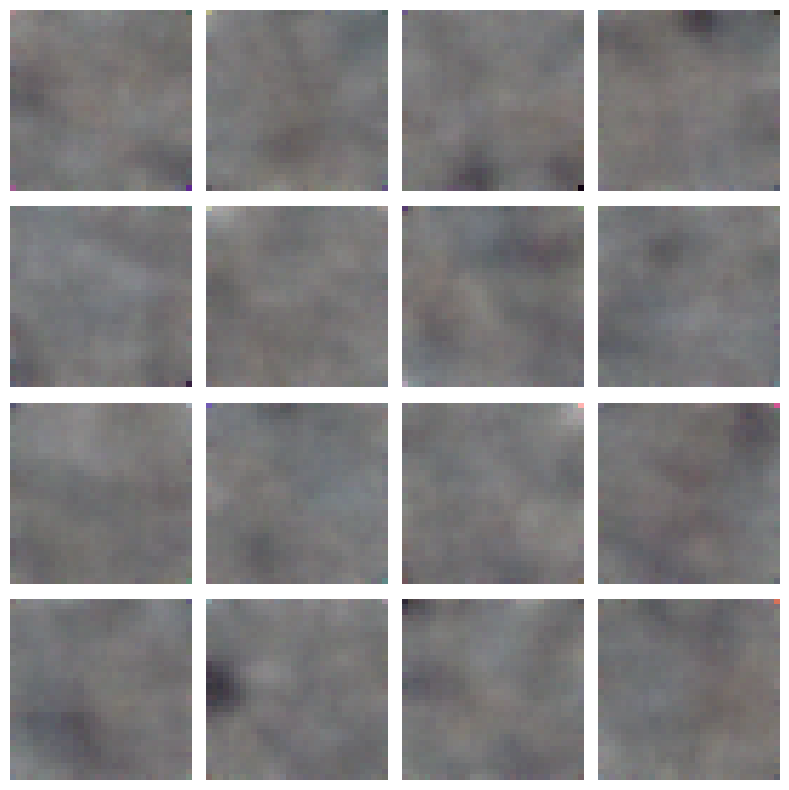

In [13]:
import matplotlib.pyplot as plt
import numpy as np

print(samples.shape)  # torch.Size([16, 3, 32, 32])

samples_np = samples.detach().cpu().numpy()  # 转换为 NumPy 数组
samples_np = np.transpose(samples_np, (0, 2, 3, 1))  # (N, C, H, W) -> (N, H, W, C)
samples_np = (samples_np - samples_np.min()) / (samples_np.max() - samples_np.min())  # 映射到 [0, 1]
#samples_np = (samples_np * 255).astype(np.uint8) # 如果需要转换为整数并显示

fig, axes = plt.subplots(4, 4, figsize=(8, 8))  # 创建 4x4 的子图
for i, ax in enumerate(axes.flat):
    ax.imshow(samples_np[i])
    ax.axis('off')  # 隐藏坐标轴

plt.tight_layout()
plt.show()

Classification

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiffusionClassifier(nn.Module):
    def __init__(self, input_channels=3, num_classes=10):
        super().__init__()
        self.num_classes = num_classes
        
        # 编码器部分保持不变
        self.enc1 = nn.Sequential(
            nn.Conv2d(input_channels + 1, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)
        
        # 瓶颈层
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.ReLU()
        )
        
        # 分类头
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )
        
        # 分割头（如果需要）
        self.segmentation_head = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 2, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 64, 3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 2, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, num_classes, 1)  # 分割时num_classes为类别数
        )
        
    def forward(self, x, t, task='classification'):
        # 添加时间编码
        t = t.float() / 1000.0
        t = t.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)
        t = t.expand(-1, 1, x.shape[2], x.shape[3])
        x = torch.cat([x, t], dim=1)
        
        # 编码器前向传播
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        
        if task == 'classification':
            return self.classifier(b)
        else:  # segmentation
            return self.segmentation_head(b)

class DiffusionForTasks:
    def __init__(self, num_timesteps=1000, beta_start=1e-4, beta_end=0.02, device='cuda'):
        self.num_timesteps = num_timesteps
        self.beta = torch.linspace(beta_start, beta_end, num_timesteps).to(device)
        self.alpha = (1 - self.beta).to(device)
        self.alpha_bar = torch.cumprod(self.alpha, dim=0).to(device)
        self.device = device
        
    def train_step(self, model, batch, labels, optimizer, task='classification'):
        optimizer.zero_grad()
        
        # 随机时间步
        t = torch.randint(0, self.num_timesteps, (batch.shape[0],), device=self.device)
        
        # 添加噪声
        noise = torch.randn_like(batch)
        noisy_batch = self.q_sample(batch, t, noise)
        
        # 前向传播
        outputs = model(noisy_batch, t, task=task)
        
        # 计算损失
        if task == 'classification':
            loss = F.cross_entropy(outputs, labels)
        else:  # segmentation
            loss = F.cross_entropy(outputs, labels, ignore_index=255)
            
        loss.backward()
        optimizer.step()
        
        return loss.item()

    def q_sample(self, x_0, t, noise=None):
        if noise is None: noise = torch.randn_like(x_0)
            
        alpha_bar_t = self.alpha_bar[t].view(-1, 1, 1, 1)
        return torch.sqrt(alpha_bar_t) * x_0 + torch.sqrt(1 - alpha_bar_t) * noise
    
    @torch.no_grad()
    def inference(self, model, shape, device, task='classification', num_steps=20):
        x = torch.randn(shape).to(device)
        timesteps = torch.linspace(self.num_timesteps - 1, 0, num_steps).long()
        
        for t in timesteps:
            t_batch = torch.full((shape[0],), t, device=device)
            x = self.denoise_step(model, x, t_batch, task)
            
        if task == 'classification':
            return model(x, torch.zeros(shape[0]).to(device), task)
        return x
    
    def denoise_step(self, model, x_t, t, task):
        betas_t = self.beta[t].view(-1, 1, 1, 1)
        sqrt_one_minus_alphas_bar_t = torch.sqrt(1 - self.alpha_bar[t]).view(-1, 1, 1, 1)
        sqrt_recip_alphas_t = torch.sqrt(1 / self.alpha[t]).view(-1, 1, 1, 1)

        # Get prediction
        pred = model(x_t, t, task)

        if task == 'segmentation':
            pred = F.softmax(pred, dim=1)
        else:  # Classification - No reshaping needed
            pass

        if task == 'classification':
            # Simple approach: Use pred to scale the noise prediction (more advanced methods exist)
            mean = sqrt_recip_alphas_t * (x_t - betas_t * pred.argmax(dim=-1).view(-1, 1, 1, 1).float() / sqrt_one_minus_alphas_bar_t)

        else: #Segmentation
            mean = sqrt_recip_alphas_t * (x_t - betas_t * pred / sqrt_one_minus_alphas_bar_t)

        if t[0].item() > 0:
            noise = torch.randn_like(x_t)
            mean += torch.sqrt(betas_t) * noise

        return mean


# 训练示例
def train_model(model, diffusion, train_loader, epochs, device, task='classification'):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    
    for epoch in range(epochs):
        total_loss = 0
        for batch, labels in train_loader:
            batch, labels = batch.to(device), labels.to(device)
            loss = diffusion.train_step(model, batch, labels, optimizer, task)
            total_loss += loss
            
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# 数据预处理
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 加载CIFAR10数据集
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)

# 分类任务
model_cls = DiffusionClassifier(input_channels=3, num_classes=10).to(device)
diffusion = DiffusionForTasks(device=device)
train_model(model_cls, diffusion, train_dataloader, epochs=3, device=device, task='classification')

# 分割任务
#model_seg = DiffusionClassifier(input_channels=3, num_classes=2).to(device)
#train_model(model_seg, diffusion, train_dataloader, epochs=100, device=device, task='segmentation')

# 分类任务推理
pred_cls = diffusion.inference(model_cls, shape=(16, 3, 32, 32), device=device, task='classification')
predicted_labels = pred_cls.argmax(1)
print(predicted_labels)

# 分割任务推理
#pred_seg = diffusion.inference(model_seg, shape=(16, 3, 32, 32), device=device, task='segmentation')
#segmentation_masks = pred_seg.argmax(1)

Files already downloaded and verified
Epoch 1/3, Loss: 2.1426
Epoch 2/3, Loss: 2.0100
Epoch 3/3, Loss: 1.9611
tensor([4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')
